In [1]:
import torch

from src.modelling.production import DeeplabMOCO, UnetMOCO

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_moco = UnetMOCO("../artifacts/weights/Unet_rn50_MOCO.pth", device)
deeplab_moco = DeeplabMOCO("../artifacts/weights/deeplab_rn50_MOCO.pth", device)

In [3]:
from src.preprocessing.reader import Reader

r = Reader("../data/digital_leaders")
image, mask = r.read_sample(1)
print(image.shape, mask.shape)

(3824, 5973, 3) (3824, 5973, 3)


In [2]:
from src.modelling.ensemble import Ensemble

ensemble = Ensemble(models={
    "unet": unet_moco,
    "deeplab": deeplab_moco
})

In [65]:
import numpy as np


def random_crop(image, mask, size):
    h, w = image.shape[:2]
    new_h, new_w = size
    top = np.random.randint(0, h - new_h)
    left = np.random.randint(0, w - new_w)
    image = image[top: top + new_h, left: left + new_w]
    mask = mask[top: top + new_h, left: left + new_w]
    return image, mask


image_tile, mask_tile = random_crop(image, mask, (512, 512))
image_tile.shape, mask_tile.shape

((512, 512, 3), (512, 512, 3))

In [66]:
pred_tile = ensemble(image_tile, return_average=True)
pred_tile.shape

(256, 256)

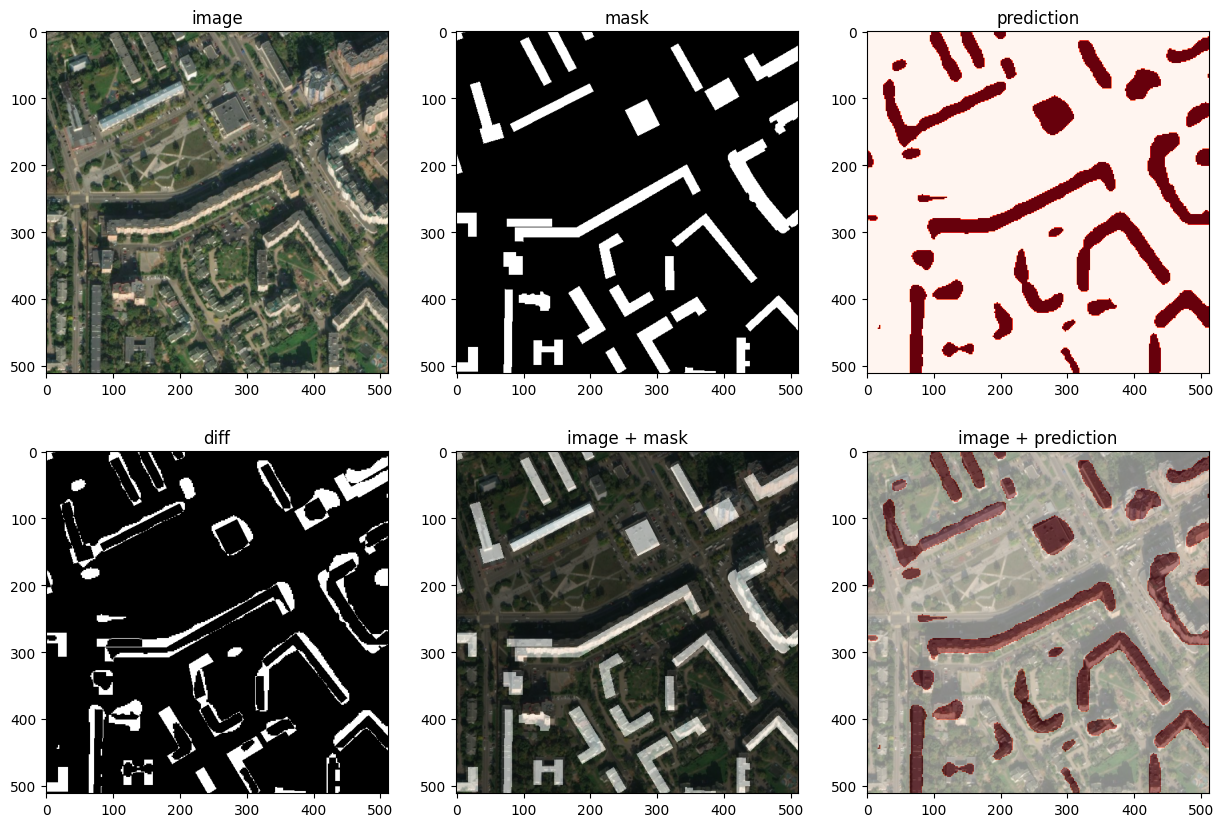

In [67]:
import matplotlib.pyplot as plt
import cv2

threshold = 0.5
binary_pred = (pred_tile > threshold).astype(np.int16)
binary_pred = cv2.resize(binary_pred, (512, 512))
binary_pred = np.expand_dims(binary_pred, -1)
mask_tile = mask_tile.astype(np.int16)

plt.subplots(2, 3, figsize=(15, 10))
plt.subplot(2, 3, 1)
plt.imshow(image_tile)
plt.title("image")
plt.subplot(2, 3, 2)
plt.imshow(mask_tile * 255, cmap='Reds')
plt.title("mask")
plt.subplot(2, 3, 3)
plt.imshow(binary_pred * 255, cmap='Reds')
plt.title("prediction")
plt.subplot(2, 3, 4)
plt.imshow(np.abs(binary_pred - mask_tile) * 255, cmap='Reds')
plt.title("diff")
plt.subplot(2, 3, 5)
plt.imshow(image_tile)
plt.imshow(mask_tile * 255, cmap='Reds', alpha=0.5)
plt.title("image + mask")
plt.subplot(2, 3, 6)
plt.imshow(image_tile)
plt.imshow(binary_pred * 255, cmap='Reds', alpha=0.5)
plt.title("image + prediction")
plt.show()